#Time-Series Visualize Intermediate Representations
ts_visualize_ir.ipynb

This notebook allows for data exploration using the intermediate representation formats (IR1 dataframes, IR2 and final numpy arrays) defined in the LLVM inspired architecure of the load_data_time_series work.

Author:  [Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), [IMICS Lab](https://imics.wp.txstate.edu/), Texas State University, 2023

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

TODO:
* 



In [4]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt # for plotting training curves
#imports for computing and displaying output metrics
from tabulate import tabulate # for verbose tables, showing data
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import urllib.request # to get files from web w/o !wget

In [10]:
# environment and execution parameters
my_dir = '.' # global for mounted drives, replace with absolute path if desired
dataset_dir = my_dir # TWristAR zip file contains TWristAR directory
working_dir = os.path.join(my_dir,'TWristAR_temp') # temp dir for processing

if not os.path.exists(working_dir):
    os.makedirs(working_dir)

interactive = True # for exploring data and functions interactively
verbose = True
interactive = True # for compatibity, this notebook is tested only as interactive
verbose = True # also mostly for compatibility

In [6]:
def get_twristar_loader():
    """checks for local file, if none downloads from IMICS repository.
    Assumes a global my_dir has been defined (default is my_dir = ".")
    :return: nothing"""
    fname = 'twristar_load_dataset.py'
    ffname = os.path.join(my_dir,fname)
    imics_url = "https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/HAR/TWristAR/twristar_load_dataset.py"
    if (os.path.exists(ffname)):
        if verbose:
            print ("Local",ffname,"found, skipping download")
    else:
        print("Downloading",fname, "from IMICS git repo")
        urllib.request.urlretrieve(imics_url, filename=fname)

get_twristar_loader()

Local ./twristar_load_dataset.py found, skipping download


In [7]:
import twristar_load_dataset as loader

# Get an IR1 dataframe to visualize and inspect

Displaying ./TWristAR/sub1/1574622389_A01F11.zip
Start Time 2019-11-24 19:06:29
 End Time  2019-11-24 19:15:03.656250112
Adding label and sub info from  ./TWristAR/sub1/1574622389_A01F11_labels.csv


,accel_x,accel_y,accel_z,accel_ttl,bvp,eda,p_temp,label,sub
datetime,,,,,,,,,
2019-11-24 19:09:05.249999872,-0.359375,-1.421875,0.187500,0.478525,29.170000,24.647041,31.190001,Walking,1.0
2019-11-24 19:09:05.281250048,-0.343750,-1.546875,0.218750,0.599637,36.430000,24.647041,31.190001,Walking,1.0
2019-11-24 19:09:05.312499968,-0.281250,-1.359375,0.281250,0.416370,31.340000,24.647041,31.190001,Walking,1.0
2019-11-24 19:09:05.343749888,-0.281250,-1.375000,0.140625,0.410497,17.190001,24.647041,31.190001,Walking,1.0
2019-11-24 19:09:05.375000064,-0.265625,-1.343750,0.109375,0.374112,4.030000,24.647041,31.190001,Walking,1.0


Label Counts - # samples before sliding window
Walking      5793
Jogging      5792
Undefined    4885
Name: label, dtype: int64


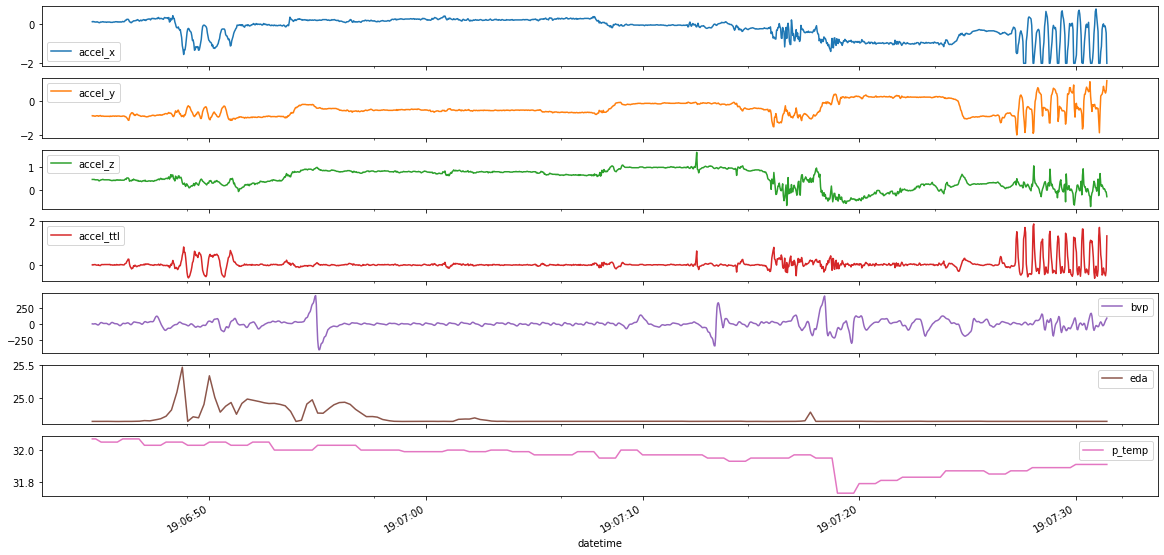

In [21]:
# TWristAR sessions upstairs/downstairs          walk/jog                    sit/stand
zip_flist = ['sub1/1574621345_A01F11.zip','sub1/1574622389_A01F11.zip','sub1/1574624998_A01F11.zip',
             'sub2/1633107019_A01F11.zip','sub2/1633108344_A01F11.zip','sub2/1633109744_A01F11.zip',
             'sub3/1633704587_A01F11.zip','sub3/1633705664_A01F11.zip','sub3/1633711821_A01F11.zip']
loader.get_TWristAR

zip_ffname = os.path.join(my_dir,'TWristAR',zip_flist[1])
loader.unzip_e4_file(zip_ffname)
ir1_df = loader.get_ir1_from_e4_dir()
print("Displaying", zip_ffname)
print("Start Time", ir1_df.index[0])
print(" End Time ", ir1_df.index[-1])
ir1_df.iloc[499:1999].plot(subplots=True, figsize=(20, 10)) # plot a few seconds of signals
# call the method to add labels from .csv and sub number
labels_ffname = os.path.splitext(zip_ffname)[0] + '_labels.csv'
print("Adding label and sub info from ",labels_ffname)
ir1_df = loader.label_df_from_csv(ir1_df, labels_ffname)
display(ir1_df[5000:5005]) # head is meaningless since start is undefined
print ("Label Counts - # samples before sliding window")
print (ir1_df['label'].value_counts())

# Get the full numpy arrays
Be careful of inspecting the test arrays!   The last version of this notebook in the internal repo has lot more per subject code from when IR3 contained both train and test data.  This was changed because it could result in leakage for more complex datasets that need further processing such as rebalancing training class.

In [38]:
all_channels = ['accel_x', 'accel_y', 'accel_z', 'accel_ttl', 'bvp', 'eda', 'p_temp']
# TODO:  above should be pulled from dataframe column names
keep_channels = ['accel_x', 'accel_y', 'accel_z', 'accel_ttl']
x_train, y_train, x_test, y_test \
                            = loader.twristar_load_dataset(
                                one_hot_encode = False,
                                keep_channel_list = keep_channels)
headers = ("Array","shape", "data type")
mydata = [("x_train:", x_train.shape, x_train.dtype),
        ("y_train:", y_train.shape, y_train.dtype),
        ("x_test:", x_test.shape, x_test.dtype),
        ("y_test:", y_test.shape, y_test.dtype)]
print("\n",tabulate(mydata, headers=headers))
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("\nInstances of each label")
# this should probably be a graph and TWristAR is different in that it uses
# strings for the labels (which take up more space and should be updated)
# when not one-hot encoded.
print("   Label #samples")
print(np.asarray((unique_elements, counts_elements)).T)
print ('\n','-'*72)


 Array     shape          data type
--------  -------------  -----------
x_train:  (2077, 96, 4)  float32
y_train:  (2077, 1)      <U10
x_test:   (1091, 96, 4)  float32
y_test:   (1091, 1)      <U10

Instances of each label
   Label #samples
[['Downstairs' '317']
 ['Jogging' '347']
 ['Sitting' '353']
 ['Standing' '342']
 ['Upstairs' '370']
 ['Walking' '348']]

 ------------------------------------------------------------------------


# Plots based on the numpy arrays

In [39]:
#Find min and max values for consistent plot scales
min_g = np.nanmin(x_train[::1])
max_g = np.nanmax(x_train[::1])
print ('min g value is',min_g,'max g value is',max_g)

min g value is -2.0 max g value is 2.0159488


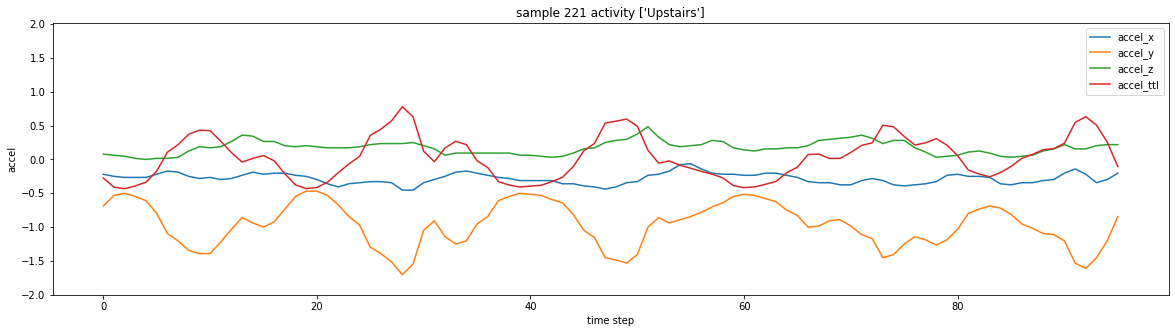

In [40]:
#@title Select Activity (each cell execution will display a random sample)
Activity_Label = "Upstairs" #@param ['Downstairs','Jogging','Sitting','Standing','Upstairs','Walking']
act_label = Activity_Label
#Plot a random sample - each time cell is run a new one appears
# find index of rows were both sub and activity match
# see https://stackoverflow.com/questions/57496890/numpy-where-matching-two-specific-columns
all_index = np.where(np.all(y_train == act_label, axis=1))
sample_num = np.random.choice(all_index[0], size=1)[0]
plt.figure(figsize=(20,5))
plt.ylim([min_g, max_g])
plt.plot(x_train[sample_num])
plt.title('sample '+str(sample_num)+' activity '+str(y_train[sample_num]))
plt.xlabel("time step")
# Note legend is specific to a version of TWristAR - need to fully implement a
# dictionary with channel names to accomodate all datasets.
plt.ylabel("accel")
plt.legend(['accel_x', 'accel_y', 'accel_z', 'accel_ttl'])
plt.show()

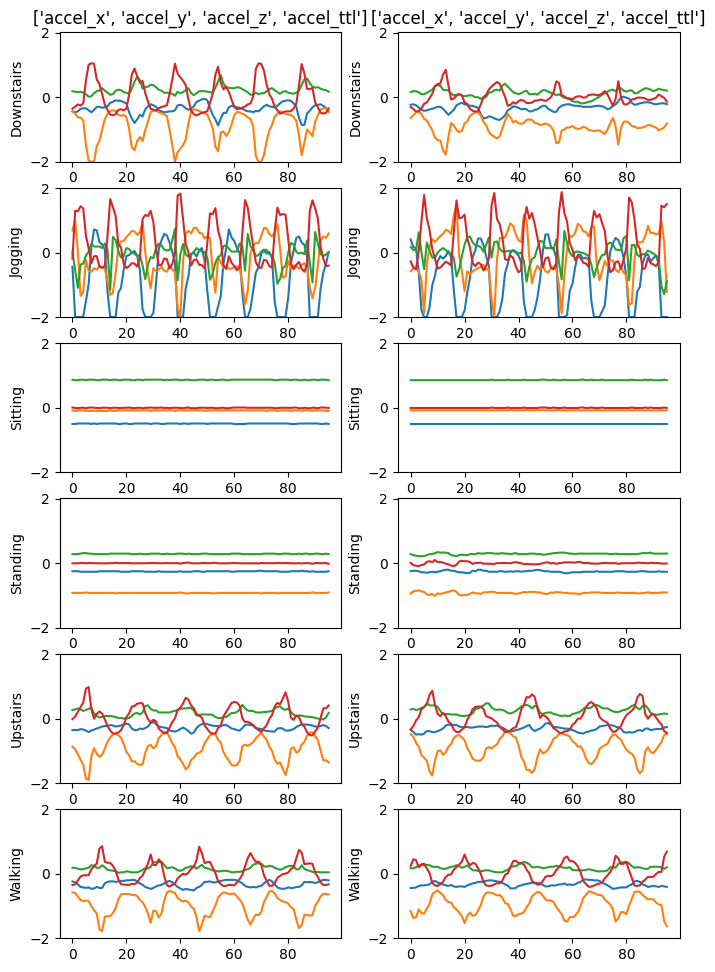

In [43]:
# Plot two random samples - this time side by side for all activities
l_sub = 1
r_sub = 2
l_idx_list = [] # empty lists to add sample numbers for left and right graphs
r_idx_list = []
unique_labels = np.unique(y_train) # note this works because TWristAR has string lbls
for act_label in unique_labels:
    all_index = np.where(np.all(y_train == act_label, axis=1))
    l_index = np.random.choice(all_index[0], size=1)[0]
    l_idx_list.append(l_index)
    all_index = np.where(np.all(y_train == act_label, axis=1))
    r_index = np.random.choice(all_index[0], size=1)[0]
    r_idx_list.append(r_index)

#all_index = np.where(np.all(y_and_sub[:,0:2] == [act_label, my_sub], axis=1))
#sample_num = np.random.choice(all_index[0], size=1)[0]
# plot side by side - leveraged from final plot in ts_throwdown which is pngs.
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html?highlight=subplots
# spacing needs to be adjusted
# see https://matplotlib.org/stable/tutorials/intermediate/gridspec.html#sphx-glr-tutorials-intermediate-gridspec-py
# see https://matplotlib.org/stable/tutorials/intermediate/tight_layout_guide.html
if (len(l_idx_list) != len(r_idx_list)):
    print("Something went wrong - number of left & right indices aren't equal")
rows = len(l_idx_list)
cols = 2
fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize = (8, 12), dpi = 100)
# might want to increase dpi if saving figure; it slows down display time
# I am not proud of the goofy list comprehension, trying to get graphs right!
for r in range(rows):
    for c in range(cols):
        if (r == 0):
            axs[r, c].set_title(keep_channels)
        #axs[r, c].set_axis_off()
        if (c == 0):
            axs[r, c].plot(x_train[l_idx_list[r]])
        else:
            axs[r, c].plot(x_train[r_idx_list[r]])
        axs[r,c].set_ylim(min_g, max_g)
        axs[r,c].set(ylabel=unique_labels[r])
        #axs[r,c].grid(True)